In [1]:
%%capture
%pip install optuna
!git clone https://github.com/rossetl/NNDL.git
%cd NNDL/Homework\ 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
BATCHSIZE = 128
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', DEVICE)

Training device: cuda


In [4]:
%%capture
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.), (1.))])
test_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transform)
full_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [50000, 10000])

train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

$D(x)$ is the discriminator network which outputs the (scalar) probability that $x$ came from training data rather than the generator. Hence, $D(x)$ should be HIGH when $x$ comes from training data and LOW when $x$ comes from the generator.

Let $z$ be a latent space vector sampled from a standard normal distribution. $G(z)$ represents the generator function which maps the latent vector $z$ to data-space. The goal of $G$ is to estimate the distribution that the training data comes from ($p_{data}$) so it can generate fake samples from that estimated distribution ($p_{g}$).

+ $D$ tries to maximize the probability it correctly classifies reals and fakes ($\log D(x)$)
+ $G$ tries to minimize the probability that $D$ will predict its outputs are fake ($\log (1-D(G(z)$).

The GAN loss function is therefore:
$$\min_G \max_D V(D,G) = \mathbb{E_{x \sim p_{data}(x)}}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z)))]$$

All model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

We can use the same architecture we already implemented for the decoder module of the autoencoder's notebook.

In [6]:
class Generator(nn.Module):
    
    def __init__(self, latent_space_dim=50, dropout=0.5):
        super().__init__()

        self.generator_fc = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=32*3*3),
            nn.Dropout(dropout),
            nn.ReLU(True),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.generator_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=0, output_padding=0, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, padding=1, output_padding=1, stride=2)
        )

    def forward(self, x):
        x = self.generator_fc(x)
        x = self.unflatten(x)
        x = self.generator_conv(x)
        x = torch.tanh(x)
        return x

## Discriminator

Again, we can recycle what we already used previously for the autoencoder. Most of the following architecture is taken from the encoder module.

In [88]:
class Discriminator(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()

        self.discriminator_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
            nn.LeakyReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.LeakyReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.discriminator_fc = nn.Sequential(
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.Dropout(dropout),
            nn.LeakyReLU(True),
            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.discriminator_cnn(x)
        x = self.flatten(x)
        x = self.discriminator_fc(x)
        return x

## Initialization

In [89]:
latent_space_dim = 100

netG = Generator(latent_space_dim=latent_space_dim, dropout=0.).to(DEVICE)
netG.apply(weights_init)
print(netG)

netD = Discriminator(dropout=0.).to(DEVICE)
netD.apply(weights_init)
print(netD)

Generator(
  (generator_fc): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0.0, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (generator_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)
Discriminator(
  (discriminator_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
 

We will use the Binary Cross Entropy loss (BCELoss) function which is defined in PyTorch. We define our real label as 1 and the fake label as 0. Finally, we set up two separate optimizers, one for $D$ and one for $G$. For keeping track of the generator’s learning progression, we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution.

In [90]:
loss_fn = nn.BCELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, latent_space_dim, device=DEVICE)

real_label = 1.
fake_label = 0.

beta1 = 0.5
lr = 2e-4

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [91]:
num_epochs = 20

img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader, 0):

        ######################
        ## Update D network ##
        ######################

        # Train with all-real batch
        netD.zero_grad()
        real_img = data[0].to(DEVICE)
        batch_size = real_img.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
        # Forward pass real batch through D
        output = netD(real_img).view(-1)
        errD_real = loss_fn(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        noise = torch.randn(batch_size, latent_space_dim, device=DEVICE)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = loss_fn(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ######################
        ## Update G network ##
        ######################

        netG.zero_grad()
        label.fill_(real_label) # Fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = loss_fn(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[1/20][0/391]	Loss_D: 1.3715	Loss_G: 0.7113	D(x): 0.5053	D(G(z)): 0.4979 / 0.4910
[1/20][100/391]	Loss_D: 0.0526	Loss_G: 4.0317	D(x): 0.9682	D(G(z)): 0.0200 / 0.0187
[1/20][200/391]	Loss_D: 0.0288	Loss_G: 4.9049	D(x): 0.9978	D(G(z)): 0.0261 / 0.0075
[1/20][300/391]	Loss_D: 0.0230	Loss_G: 4.9480	D(x): 0.9953	D(G(z)): 0.0180 / 0.0077
[2/20][0/391]	Loss_D: 0.1390	Loss_G: 3.8341	D(x): 0.9917	D(G(z)): 0.1214 / 0.0230
[2/20][100/391]	Loss_D: 0.3738	Loss_G: 5.5925	D(x): 0.7754	D(G(z)): 0.0108 / 0.0039
[2/20][200/391]	Loss_D: 1.3301	Loss_G: 5.0570	D(x): 0.9959	D(G(z)): 0.7191 / 0.0069
[2/20][300/391]	Loss_D: 0.0700	Loss_G: 3.8393	D(x): 0.9580	D(G(z)): 0.0246 / 0.0229
[3/20][0/391]	Loss_D: 0.0146	Loss_G: 4.9908	D(x): 0.9933	D(G(z)): 0.0079 / 0.0073
[3/20][100/391]	Loss_D: 0.3285	Loss_G: 2.8387	D(x): 0.8554	D(G(z)): 0.1505 / 0.0609
[3/20][200/391]	Loss_D: 0.5644	Loss_G: 3.3124	D(x): 0.8727	D(G(z)): 0.3359 / 0.0369
[3/20][300/391]	Loss_D: 0.7273	Loss_G: 2.2092	D(x): 0.7185	D(G(z)): 0.2441 / 0.115

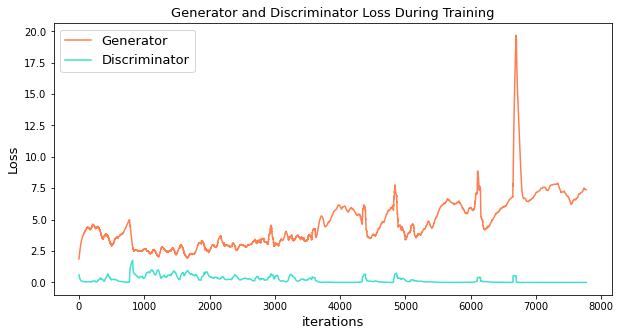

In [92]:
N = 50
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training", size=13)
plt.plot(np.convolve(G_losses, np.ones(N)/N, mode='valid'), c='coral',label="Generator")
plt.plot(np.convolve(D_losses, np.ones(N)/N, mode='valid'), c='turquoise', label="Discriminator")
plt.xlabel("iterations", size=13)
plt.ylabel("Loss", size=13)
plt.legend(fontsize=13)
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

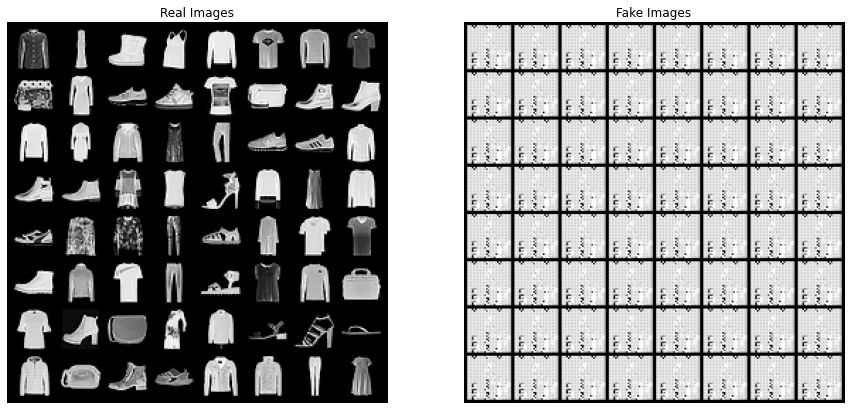

In [94]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(val_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()